Importing the stuff we need

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import nltk

2023-11-27 11:32:31.962492: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 11:32:31.962531: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 11:32:31.962545: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 11:32:31.966855: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /home/sgzmd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Defining some constants

In [3]:
# Constants
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MAX_TOKENS = 128

Let's read and pre-process the data

In [4]:
df = pd.read_csv("../full-flibusta-filenames.csv")  # Load the CSV file into a pandas DataFrame

# drop all non-string records, unclear where they are coming from
df = df[df.apply(lambda row: isinstance(row['body'], str) and isinstance(row['genre'], str), axis=1)]

def is_sf_genre(genre: str) -> bool:
    return genre.startswith('sf') or genre == 'popadanec' or genre == 'litrpg'

# define is_sf label
df['is_sf'] = df['genre'].apply(lambda genres: any(is_sf_genre(genre) for genre in genres.split(',')))
df.head()

,body,genre,selected,file_name,is_sf
0,"орда подростков, от грохота дребезжали стекла...",sf,0,110519.fb2,True
1,беседой Штирлица и Мюллера и на мой вопрос ко...,sf,0,110523.fb2,True
2,"повалившийся на песок, мгновенно вскочил, при...",sf,0,110524.fb2,True
3,"была неизбежно наступить ночь – черная, безна...",sf,0,110526.fb2,True
4,"На полу валялись скорченные окурки папирос, в...",sf_fantasy,0,110525.fb2,True


In [6]:
# Filter the dataframe based on the conditions
df_selected_1 = df[(df['selected'] == 1)]
df_selected_0 = df[(df['selected'] == 0) & (~df['is_sf'])]

# -1 are manually selected negative samples
df_selected_neg = df[(df['selected'] == -1)]

# Sample the same number of records where selected = 0
df_selected_0_sampled = df_selected_0.sample(n=len(df_selected_1), random_state=42)

negative_samples = pd.concat([df_selected_0_sampled, df_selected_neg])

# Set 'selected' to 0 for all negative_samples
negative_samples['selected'] = 0

# Concatenate the two dataframes
new_df = pd.concat([df_selected_1, negative_samples])

# Reset the index of the new dataframe
new_df.reset_index(drop=True, inplace=True)

# Print the new dataframe
new_df.sample(10)


,body,genre,selected,file_name,is_sf
150,"Сознание офицера спецназа с позывным «Ермак», ...","sf_history,popadanec,sf_action",1,556768.fb2,True
665,"за товаром, но тот прибежал назад, бледный и ...",prose_contemporary,0,76297.fb2,False
709,Любовь случается. Любовь бывает. Она не спраши...,"prose_classic,russian_contemporary",0,689511.fb2,False
755,\n Я морально истощена. Я теряюсь в догадка...,"love_erotica,love_contemporary",0,461360.fb2,False
532,\n В 1930–1932 годах Н. Н. Урванцев руковод...,adv_geo,0,297834.fb2,False
92,\n \n Вторая книга цикла!\n ...,",sf_action",1,500364.fb2,True
816,\n Наше государство на севере простирается ...,science,0,322874.fb2,False
840,\n \n\t\n\t\t 15 мая 1975 года пятнад...,love_detective,0,469916.fb2,False
627,Этим же самолетом улетал в Баку на гастроли б...,prose_contemporary,0,109076.fb2,False
600,"\n“Прежде всего я считаю нужным сказать, что я...","nonf_biography,religion",0,217287.fb2,False


Defining tokenizer and some helper methods

In [8]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Function to segment and tokenize text
def segment_and_tokenize(text):
    # Split text into sentences
    sentences = sent_tokenize(text, language='russian')
    tokenized_output = []
    attention_mask_output = []

    for sentence in sentences:
        # Tokenize each sentence
        tokens = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_TOKENS, 
                                       truncation=True, padding='max_length', return_tensors='tf')
        tokenized_output.append(tokens['input_ids'])
        attention_mask_output.append(tokens['attention_mask'])

        # Check if we've reached the maximum number of tokens
        if sum([len(t[0]) for t in tokenized_output]) >= MAX_TOKENS:
            break

    # Combine tokenized sentences up to the maximum length
    input_ids = tf.concat(tokenized_output, axis=1)[0,:MAX_TOKENS]
    attention_mask = tf.concat(attention_mask_output, axis=1)[0,:MAX_TOKENS]

    return input_ids, attention_mask

Let's run the tokenization and segmentation of the data

In [9]:
# Apply the function to the dataset
new_df['segmented_data'] = new_df['body'].apply(segment_and_tokenize)
new_df[['tokens', 'attention_mask']] = pd.DataFrame(new_df['segmented_data'].tolist(), index=new_df.index)

2023-11-27 11:34:30.753786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 11:34:30.761675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 11:34:30.761712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 11:34:30.762775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 11:34:30.762801: I tensorflow/compile

Now let's prepare and split the dataset

In [10]:
# Prepare dataset
X_ids = np.array(new_df['tokens'].tolist())
X_mask = np.array(new_df['attention_mask'].tolist())

y = new_df['is_sf'].values
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(X_ids, X_mask, y, test_size=0.2)


Let's load the model now and define how we are fine-tuning it

In [11]:
bert = TFAutoModel.from_pretrained(MODEL_NAME, from_pt=True)
input_ids = Input(shape=(MAX_TOKENS,), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(MAX_TOKENS,), dtype=tf.int32, name='attention_mask')

embeddings = bert(input_ids, attention_mask=input_mask)[0]
pooled = GlobalMaxPool1D()(embeddings)
output = Dense(1, activation='sigmoid')(pooled)

model = Model(inputs=[input_ids, input_mask], outputs=output)

2023-11-27 11:34:37.168361: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a 

In [12]:
model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:

history = model.fit([X_train_ids, X_train_mask], y_train, batch_size=16, epochs=5, validation_split=0.2)

Epoch 1/5


2023-11-27 11:34:54.861934: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f44e8192000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-27 11:34:54.861962: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-11-27 11:34:54.865412: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-27 11:34:54.976797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-27 11:34:55.016256: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 [==============================] - ETA: 0s - loss: 0.5626 - accuracy: 0.7078

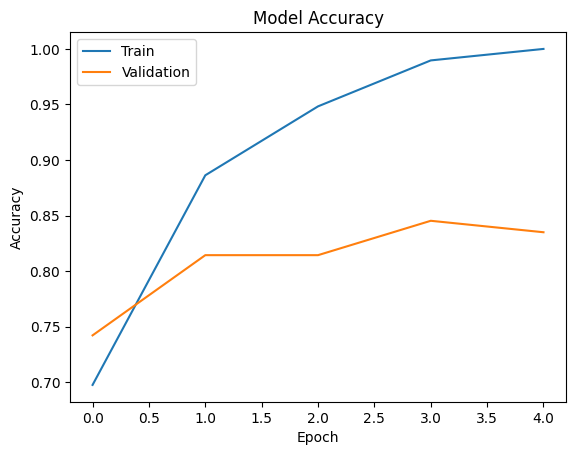

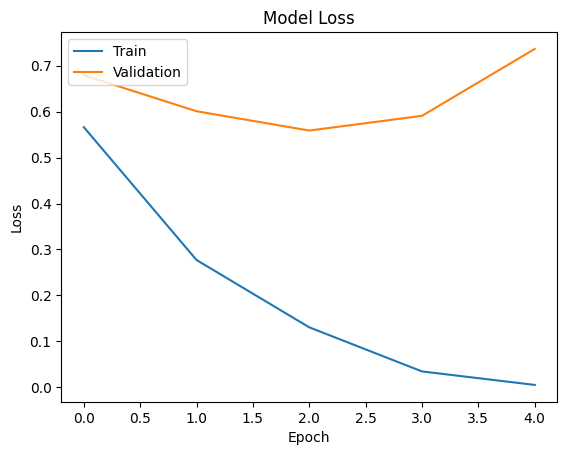

In [ ]:
import matplotlib.pyplot as plt

# 'history' is the object returned by the model.fit() method in TensorFlow

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate([X_test_ids, X_test_mask], y_test)

4/4 [==============================] - 1s 200ms/step - loss: 0.5840 - accuracy: 0.8115


[0.5840109586715698, 0.811475396156311]

In [ ]:
model.save('segmented_model_selected.keras')

/home/sgzmd/code/FliNet/toy/venv/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [ ]:
df_sf = df[(df['selected'] == 0) & df['is_sf']]

df_sf['segmented_data'] = df_sf['body'].apply(segment_and_tokenize)
df_sf[['tokens', 'attention_mask']] = pd.DataFrame(df_sf['segmented_data'].tolist(), index=df_sf.index)

inference_X_ids = np.array(df_sf['tokens'].tolist())
inference_X_mask = np.array(df_sf['attention_mask'].tolist())


# Make predictions
predictions = model.predict([inference_X_ids, inference_X_mask])

# Get the top 100 results
top_1000_results = df_sf.iloc[predictions.argsort(axis=0)[-1000:].flatten()]


/tmp/ipykernel_401456/2850528996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sf['segmented_data'] = df_sf['body'].apply(segment_and_tokenize)
/tmp/ipykernel_401456/2850528996.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sf[['tokens', 'attention_mask']] = pd.DataFrame(df_sf['segmented_data'].tolist(), index=df_sf.index)
/tmp/ipykernel_401456/2850528996.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

4411/4411 [==============================] - 1012s 229ms/step
                                                     body  \
98480   \n    Другой мир, другой язык, другая культура...   
54834   \n    Попасть в другой мир… Неизвестность, опа...   
200991  \n        Черная цитадель. Черный город, окруж...   
198712  Король умер! Да здравствует король! Однако юны...   
1765    \nАнонс\nБоги могут все. Они творят и разрушаю...   
...                                                   ...   
220691  …Мир Большого Киева. Совершенно невероятная см...   
66707   \n    …Мир Большого Киева.\n    Совершенно нев...   
218829  …Мир Большого Киева.\nСовершенно невероятная с...   
150687  \n    Я баг… Системная ошибка мира «Нибелиум»,...   
129190  \n    Армия, гражданка, мирная жизнь… Всё оста...   

                                                    genre  selected  \
98480            fanfiction,network_literature,sf_fantasy         0   
54834                                          sf_fantasy      

In [ ]:
# top_1000_results.to_csv('top_100_results.csv', index=False)

In [ ]:
top_1000_results['file_name'].to_csv('top_100_filenames.txt', index=False, header=False)
